# TEST PUNCC - Conformal prediction

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
import os
# %matplotlib inline: only draw static
# images in the notebook
%matplotlib inline

In [26]:
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor
from deel.puncc.api.prediction import BasePredictor,MeanVarPredictor,DualPredictor
from deel.puncc.regression import SplitCP,CQR,LocallyAdaptiveCP,EnbPI,AdaptiveEnbPI,CVPlus
from deel.puncc.plotting import plot_prediction_intervals
from deel.puncc.api.conformalization import ConformalPredictor
from deel.puncc.api.prediction import BasePredictor
from deel.puncc.api.calibration import BaseCalibrator
from deel.puncc.api.splitting import KFoldSplitter
from deel.puncc.api import nonconformity_scores
from deel.puncc.api import prediction_sets
from deel.puncc.metrics import regression_mean_coverage
from deel.puncc.metrics import regression_sharpness

# LOAD DATA

In [27]:

def read_split_csv(folder_path):
    """Load csv files in folder path in a dictionnary of pandas dataframes"""
    datasets = dict()
    for f in os.listdir(folder_path):
        print(f)
        datasets[f[:-4]] = pd.read_csv(os.path.join(folder_path, f), index_col=0)

    return datasets

In [28]:
# read csvs for train/val/test + lourd 

datasets = read_split_csv("../../Data/split_quad/")

# remove columns 
cols_ignored = ["time_start","battery_voltage","battery_current","power_smoothed","position_x","position_y","altitude","route"]
target = ["power"]
for k in datasets.keys():
    datasets[k] = datasets[k].drop(columns = cols_ignored)

print(datasets['val'].columns[:-1])
datasets['lourd'].head(5)   

train.csv
test.csv
val.csv
lourd.csv
Index(['flight', 'time', 'wind_speed', 'wind_angle', 'position_z',
       'orientation_x', 'orientation_y', 'orientation_z', 'orientation_w',
       'velocity_x', 'velocity_y', 'velocity_z', 'angular_x', 'angular_y',
       'angular_z', 'linear_acceleration_x', 'linear_acceleration_y',
       'linear_acceleration_z', 'speed', 'payload'],
      dtype='object')


,flight,time,wind_speed,wind_angle,position_z,orientation_x,orientation_y,orientation_z,orientation_w,velocity_x,...,velocity_z,angular_x,angular_y,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,power
index,,,,,,,,,,,,,,,,,,,,,
22085,76,0.0,1.3,221,271.659393,0.031656,-0.003266,-0.781163,0.623515,0.005638,...,0.010004,0.001404,-0.001690,0.007516,0.441685,-0.439657,-9.789563,4,750,7.700636
22086,76,0.2,1.3,230,271.660441,0.031672,-0.003279,-0.781197,0.623472,0.006756,...,0.011219,0.003334,0.002115,-0.003717,0.455686,-0.438917,-9.807742,4,750,77.439395
22087,76,0.3,1.3,234,271.659338,0.031759,-0.002978,-0.781208,0.623456,0.001088,...,0.010285,-0.002417,0.008522,-0.025537,0.381129,-0.484429,-9.774743,4,750,12.002027
22088,76,0.5,1.5,241,271.660378,0.031749,-0.003085,-0.781182,0.623488,0.003102,...,0.010345,-0.006565,0.031952,0.002586,0.438305,-0.427297,-9.782342,4,750,234.236860
22089,76,0.6,1.5,246,271.658821,0.031864,-0.002958,-0.781288,0.623350,0.000531,...,0.007867,-0.003637,-0.003621,-0.008331,0.469687,-0.476638,-9.808387,4,750,52.691091


In [29]:
df_train=datasets['train']
df_train=df_train.sort_values(by=['time'])
X_train=df_train[df_train.columns[:-1]]
X_train=X_train.values
y_train=df_train[df_train.columns[-1]]
y_train=y_train.values
print ('Number of samples in train : {}'.format(X_train.shape[0]))

Number of samples in train : 139006


# Linear prediction and Split onformal prediction (SplitCP)

In [89]:



# Create a HistGradientBoostingRegressor model and wrap it in a predictor
rf_model = HistGradientBoostingRegressor(loss="squared_error",random_state=42, 
                                         max_iter=200, learning_rate=0.3)
rf_predictor = BasePredictor(rf_model, is_trained=False)

# CP method initialization
cp_method = SplitCP(rf_predictor)

# The call to `fit` trains the model and computes the nonconformity
# scores on the calibration set
cp_method.fit(X=X_train, y=y_train, fit_ratio=.8)


# CQR 

In [46]:
 # Lower quantile regressor
regressor_q_low = HistGradientBoostingRegressor(max_iter=200, learning_rate=0.3,loss="quantile", quantile=.2/2 )
# Upper quantile regressor
regressor_q_hi = HistGradientBoostingRegressor(max_iter=200, learning_rate=0.3,loss="quantile", quantile=1 - .2/2)
# Wrap models in predictor
rf_predictor = DualPredictor(models=[regressor_q_low, regressor_q_hi])

# CP method initialization
cp_method = CQR(rf_predictor)

# The call to `fit` trains the model and computes the nonconformity
# scores on the calibration set
cp_method.fit(X=X_train, y=y_train, fit_ratio=.8)

# LocallyAdaptiveCP

In [33]:
# Create two models mu (mean) and sigma (dispersion)

mu_model = HistGradientBoostingRegressor(loss="squared_error",random_state=42, 
                                         max_iter=200, learning_rate=0.3)
sigma_model = HistGradientBoostingRegressor(loss="squared_error",random_state=42, 
                                         max_iter=200, learning_rate=0.3)


# Wrap models in a mean/variance predictor
mean_var_predictor = MeanVarPredictor(models=[mu_model, sigma_model])

# CP method initialization
cp_method = LocallyAdaptiveCP(mean_var_predictor)

# The call to `fit` trains the model and computes the nonconformity
# scores on the calibration set
cp_method.fit(X=X_train, y=y_train, fit_ratio=.8)

# CV + (cross-validation) method

In [81]:
# Create a HistGradientBoostingRegressor model and wrap it in a predictor
rf_model = HistGradientBoostingRegressor(loss="squared_error",random_state=42, 
                                         max_iter=200, learning_rate=0.3)
rf_predictor = BasePredictor(rf_model, is_trained=False)

# CP method initialization
cp_method = CVPlus(rf_predictor, K=20, random_state=42)

# The call to `fit` trains the model and computes the nonconformity
# scores on the K-fold calibration sets
cp_method.fit(X=X_train, y=y_train)

# Ensemble Batch Prediction Intervals (EnbPI) method

In [66]:
# Create rf regressor
rf_model = HistGradientBoostingRegressor(loss="squared_error",random_state=42, max_iter=200, learning_rate=0.3)
# Wrap model in a predictor
rf_predictor = BasePredictor(rf_model)
# CP method initialization
cp_method = EnbPI(rf_predictor,B=30, agg_func_loo=np.mean,random_state=42)

# The call to `fit` trains the model and computes the nonconformity
# scores on the calibration set
cp_method.fit(X=X_train, y=y_train)

# Adaptive EnbPI method

In [74]:
# Create two models mu (mean) and sigma (dispersion)

mu_model = HistGradientBoostingRegressor(loss="squared_error",random_state=42, 
                                         max_iter=200, learning_rate=0.3)
sigma_model = HistGradientBoostingRegressor(loss="squared_error",random_state=42, 
                                         max_iter=200, learning_rate=0.3)

# Wrap models in a mean/variance predictor
mean_var_predictor = MeanVarPredictor(models=[mu_model, sigma_model])

# CP method initialization
cp_method = AdaptiveEnbPI(mean_var_predictor,B=30, agg_func_loo=np.mean,random_state=42)

# The call to `fit` trains the model and computes the nonconformity
# scores on the calibration set
cp_method.fit(X=X_train, y=y_train)

# TEST

In [90]:
#### Test
df_test=datasets['test']
df_test=df_test[df_test["flight"]==210]   #60,156,210
X_test=df_test[df_test.columns[:-1]]
X_test=X_test.values
y_test=df_test[df_test.columns[-1]]
y_test=y_test.values

print ('Number of samples in test : {}'.format(X_test.shape[0]))

Number of samples in test : 275


# LOURD

In [86]:
#### Test
df_test=datasets['lourd']
df_test=df_test[df_test["flight"]==76]   #60,156,210
X_test=df_test[df_test.columns[:-1]]
X_test=X_test.values
y_test=df_test[df_test.columns[-1]]
y_test=y_test.values

print ('Number of samples in test : {}'.format(X_test.shape[0]))

Number of samples in test : 1086


# PREDICT

In [91]:

# The predict method infers prediction intervals with respect to
# the significance level alpha = 10%
y_pred, y_pred_lower, y_pred_upper = cp_method.predict(X_test, alpha=.1)
# Compute marginal coverage and average width of the prediction intervals
coverage = regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = regression_sharpness(y_pred_lower=y_pred_lower,
                                     y_pred_upper=y_pred_upper)
print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average width: {np.round(width, 2)}")





Marginal coverage: 0.96
Average width: 152.61


# Visualisation

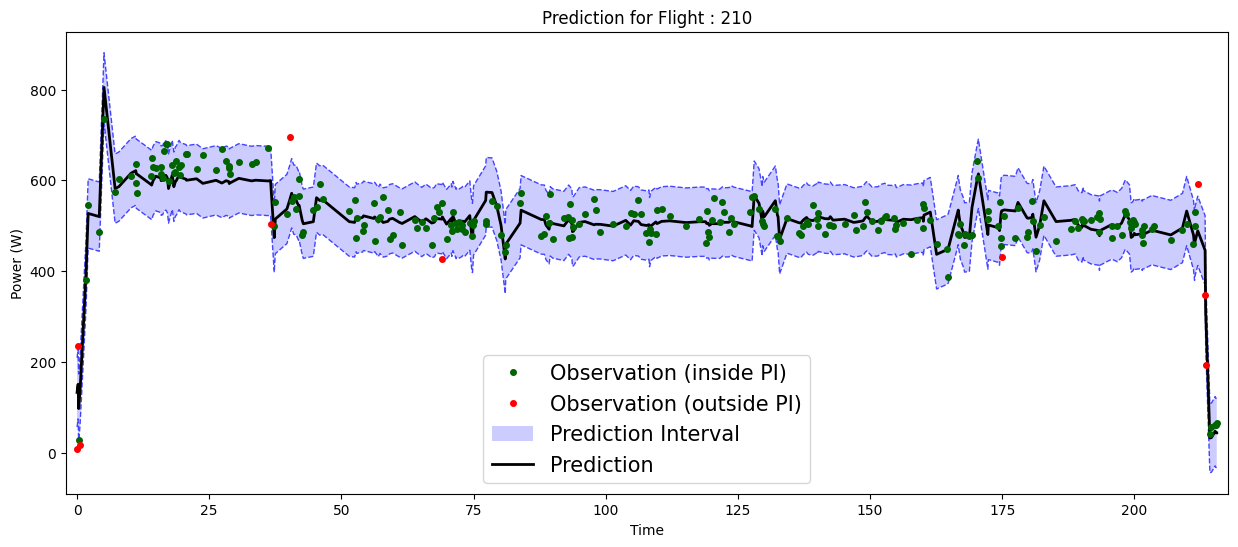

In [92]:
ax = plot_prediction_intervals(
        X = X_test[:,1],
        y_true=y_test,
        y_pred=y_pred,
        y_pred_lower=y_pred_lower,
        y_pred_upper=y_pred_upper,
        loc="lower center")

_ = ax.set_xlabel("Time")
_ = ax.set_ylabel("Power (W)")
_ = ax.set_title( 'Prediction for Flight : {}'.format((int)(X_test[0,0])))